In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.formula.api as smf
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

## Importar Datos

In [2]:
data = pd.read_csv('Hitters.csv')
data.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


## Explicación de variables

### **Player Performance (1986 Season):**
1. **`AtBat`**: Number of times the player was at bat (faced a pitcher) in 1986.  
2. **`Hits`**: Total hits (successful contact with the ball resulting in reaching base) in 1986.  
3. **`HmRun`**: Number of home runs (hits allowing the batter to circle all bases) in 1986.  
4. **`Runs`**: Total runs scored (times crossing home plate) in 1986.  
5. **`RBI`**: Runs Batted In (number of runs a player caused by their hits, including home runs) in 1986.  
6. **`Walks`**: Number of times the player was walked (awarded first base due to four balls) in 1986.  

---

### **Career Statistics (Cumulative Until 1986):**
7. **`CAtBat`**: Total times at bat during the player’s entire career.  
8. **`CHits`**: Total career hits.  
9. **`CHmRun`**: Total career home runs.  
10. **`CRuns`**: Total runs scored in the player’s career.  
11. **`CRBI`**: Total career Runs Batted In.  
12. **`CWalks`**: Total career walks.  

---

### **Player Demographics:**
13. **`Years`**: Number of years the player has been in the major leagues (experience).  

---

### **League/Division Affiliation:**
14. **`League`**: Player’s league at the **end of 1986** (`A` = American League, `N` = National League).  
15. **`Division`**: Player’s division at the **end of 1986** (`E` = East, `W` = West).  

---

### **Defensive Performance (1986 Season):**
16. **`PutOuts`**: Number of defensive plays where the player directly caused an out (e.g., catching a fly ball).  
17. **`Assists`**: Number of times the player contributed to an out made by another fielder.  
18. **`Errors`**: Number of fielding mistakes that benefited the opposing team.  

---

### **Salary:**
19. **`Salary`**: The player’s **1987 annual salary** (on opening day), measured in **thousands of dollars** (e.g., `500` = \$500,000). Missing values are marked as `NA`.  

---

### **Post-1986 League:**
20. **`NewLeague`**: Player’s league at the **beginning of 1987** (`A` or `N`). Indicates potential league changes after 1986.  

## Análisis de datos

Tenemos 3 variables categóricas: `League`, `Division` y `NewLeague`, para poder utilizarlas las haremos dummies.

In [3]:
data = pd.get_dummies(data, columns=['League','Division','NewLeague'])
target = 'Salary'
data.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,PutOuts,Assists,Errors,Salary,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
0,293,66,1,30,29,14,1,293,66,1,...,446,33,20,NaN,True,False,True,False,True,False
1,315,81,7,24,38,39,14,3449,835,69,...,632,43,10,475.0,False,True,False,True,False,True
2,479,130,18,66,72,76,3,1624,457,63,...,880,82,14,480.0,True,False,False,True,True,False
3,496,141,20,65,78,37,11,5628,1575,225,...,200,11,3,500.0,False,True,True,False,False,True
4,321,87,10,39,42,30,2,396,101,12,...,805,40,4,91.5,False,True,True,False,False,True


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        322 non-null    int64  
 1   Hits         322 non-null    int64  
 2   HmRun        322 non-null    int64  
 3   Runs         322 non-null    int64  
 4   RBI          322 non-null    int64  
 5   Walks        322 non-null    int64  
 6   Years        322 non-null    int64  
 7   CAtBat       322 non-null    int64  
 8   CHits        322 non-null    int64  
 9   CHmRun       322 non-null    int64  
 10  CRuns        322 non-null    int64  
 11  CRBI         322 non-null    int64  
 12  CWalks       322 non-null    int64  
 13  PutOuts      322 non-null    int64  
 14  Assists      322 non-null    int64  
 15  Errors       322 non-null    int64  
 16  Salary       263 non-null    float64
 17  League_A     322 non-null    bool   
 18  League_N     322 non-null    bool   
 19  Division

Vemos que existen valores nulos para el salario que es nuestra variable a predecir, por lo que vemos cuantos datos faltantes hay.

In [5]:
pd.DataFrame(data.isnull().sum()).T

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,PutOuts,Assists,Errors,Salary,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,59,0,0,0,0,0,0


La variable de salario tiene 59 valores faltantes, los cuales debemos de quitar de nuestros datos.

In [6]:
data = data[data['Salary'].notnull()]

In [7]:
class Models:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)

    def calibracion(self, predicciones, y, bins):
        df_calibracion = pd.DataFrame({
            'predicciones': predicciones,
            'y': y
        })
        df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q = bins, labels=False) + 1
        grouped = df_calibracion.groupby('bins').mean()
        plt.plot(grouped.predicciones, grouped.y, marker='o', label = 'Modelo', color = 'blue')
        plt.plot(grouped.predicciones, grouped.predicciones, marker='o', label = 'Real', color = 'red')
        plt.xlabel('Predicción')
        plt.ylabel('Real')
        plt.legend()
        plt.grid()    

    def linear_regression(self):
        model = LinearRegression().fit(self.X_train, self.y_train)
        predicciones = model.predict(self.X_test)
        r2 = r2_score(self.y_test, predicciones)
        # Llama a la función de calibración para la gráfica
        self.calibracion(predicciones, self.y_test, 10)
        return print(f'R2 del modelo: {r2:.4f}')
    
    def linear_ridge(self):
        model = Ridge().fit(self.X_train, self.y_train)
        predicciones = model.predict(self.X_test)
        r2 = r2_score(self.y_test, predicciones)
        # Llama a la función de calibración para la gráfica
        self.calibracion(predicciones, self.y_test, 10)
        return print(f'R2 del modelo: {r2:.4f}')

    def linear_lasso(self):
        model = Lasso().fit(self.X_train, self.y_train)
        predicciones = model.predict(self.X_test)
        r2 = r2_score(self.y_test, predicciones)
        # Llama a la función de calibración para la gráfica
        self.calibracion(predicciones, self.y_test, 10)
        return print(f'R2 del modelo: {r2:.4f}')
    
    def polinomial_regression(self, degree=2):
        """
        Por defecto usa Lasso para regularización
        """
        X_scaled = StandardScaler().fit_transform(self.X)
        poly_features = PolynomialFeatures(degree=degree)
        X_poly = poly_features.fit_transform(X_scaled)
        X_train, X_test, y_train, y_test = train_test_split(X_poly, self.y, test_size=0.2, random_state=42)
        model = Lasso().fit(X_train, y_train)
        predicciones = model.predict(X_test)
        # Llama a la función de calibración para la gráfica
        self.calibracion(predicciones, self.y_test, 10)
        r2 = r2_score(y_test, predicciones)
        return print(f'R2 del modelo: {r2:.4f}')
    
    def knn(self):
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(self.X_train)
        X_test_scaled = scaler.transform(self.X_test)

        r2s = [r2_score(self.y_test, KNeighborsRegressor(n_neighbors=i).fit(X_train_scaled, self.y_train).predict(X_test_scaled)) for i in range(1, 50)]

        r2s_df = pd.DataFrame({
            'nn': range(1, 50),
            'r2': r2s
        })

        opt_nn = r2s_df[r2s_df['r2'] == r2s_df['r2'].max()]['nn'].values[0]
        model = KNeighborsRegressor(n_neighbors=opt_nn).fit(X_train_scaled, self.y_train)
        predicciones = model.predict(X_test_scaled)
        # Llama a la función de calibración para la gráfica
        self.calibracion(predicciones, self.y_test, 10)
        return r2s_df[r2s_df['r2'] == r2s_df['r2'].max()]

In [8]:
def scatterplots(df, num_features, target):
    for i in num_features:
        plt.scatter(df[i],df[target])
        plt.title(f'{i} vs {target}')
        plt.xlabel(i)
        plt.ylabel(target)
        plt.show()

def bivariado(df, num_features, bins=10):
    for feature in num_features:
        df[f'{feature}_bins'] = pd.qcut(df[feature], q=bins, labels=False) + 1
        grouped = df.groupby(f'{feature}_bins').mean()
        plt.plot(grouped[feature], grouped['Salary'], marker='o', c='navy')
        plt.title(f'{feature} vs Salary')
        plt.xlabel(feature)
        plt.ylabel('Salary')
        plt.grid()
        plt.show()

## Modelos base

### Modelos lineales

In [9]:
X = data.copy()
X = X.drop(columns=[target])
y = data[target]

R2 del modelo: 0.2907


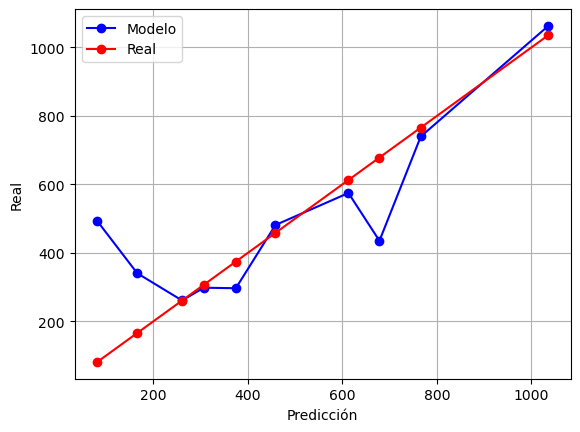

In [10]:
Models(X, y).linear_regression()

R2 del modelo: 0.2919


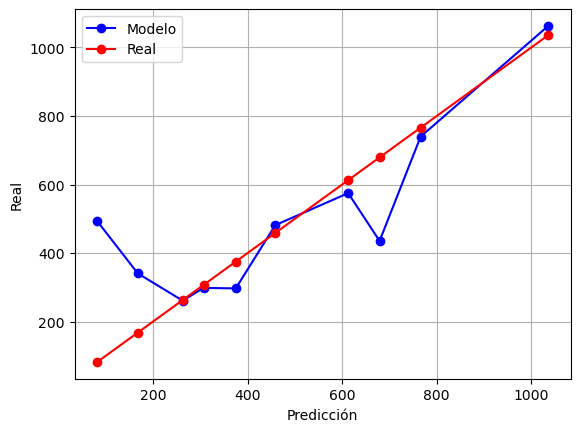

In [11]:
Models(X, y).linear_ridge()

R2 del modelo: 0.2942


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.948e+06, tolerance: 4.367e+03
  model = cd_fast.enet_coordinate_descent(


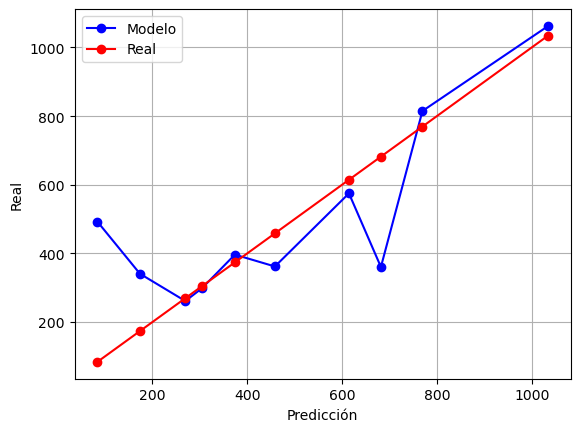

In [12]:
Models(X, y).linear_lasso()

Relizamos una regresión lineal múltiple con todas nuestras varibles usando un regresión normal, otra ridge y una lasso. Vemos que el mejor resultado es la regresión con regularización Lasso, con un r2 de 0.2941, sin embargo es bastante bajo, por lo que el modelo no es bueno. Se probarán modelos polinomiales para ver los resultados.

### Modelos polinomiales

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.250e+05, tolerance: 4.367e+03
  model = cd_fast.enet_coordinate_descent(


R2 del modelo: 0.2153


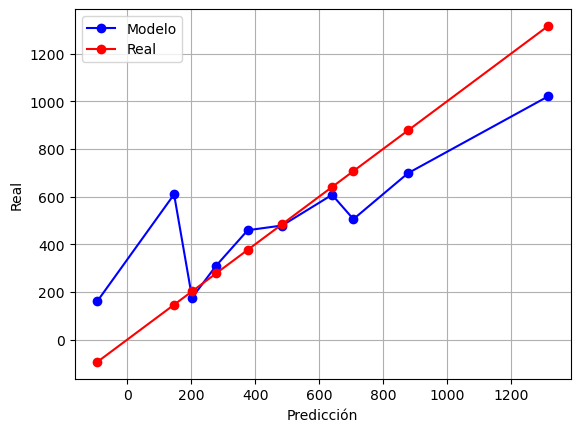

In [13]:
Models(X, y).polinomial_regression(2)

R2 del modelo: -0.1261


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.742e+05, tolerance: 4.367e+03
  model = cd_fast.enet_coordinate_descent(


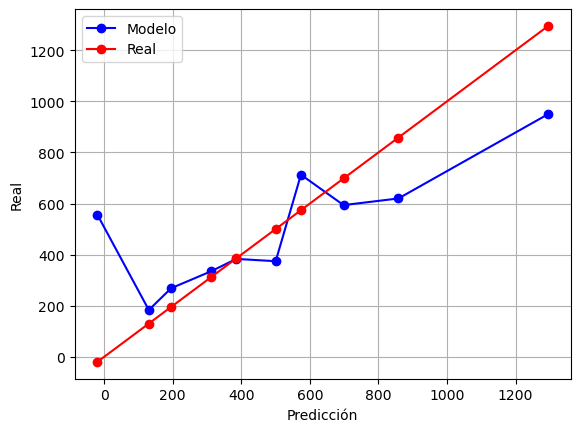

In [14]:
Models(X, y).polinomial_regression(3)

Vemos que el uso de los modelos polinomiales no mejoró el r2 del modelo, por lo que no son de gran utilidad, sinedo Lasso todavía el mejor modelo.

### KNN

,nn,r2
7,8,0.305726


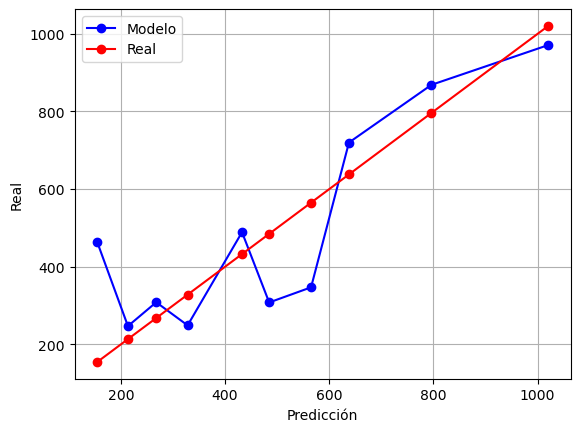

In [15]:
Models(X, y).knn()

Ahora utilizamos un modelo de KNN que con 8 vecinos obtuvo el mejor r2 de 0.3057, sinedo hasta el momento el mejor modelo.

### Regresión OLS

En está parte utilizaremos la regresión lineal multiple de OLS, para ver el p-value de nuestras variables y ver cuales son significativas, e ir quitando la del p-avlues más alto de forma iterativa hasta tener solo variables significativas para nuestro modelo. En esta parte no realizamos train y test, pues es con la intención de ver que variables en teoría son importantes para el modelo.

In [16]:
model = smf.ols('Salary ~ ' + ' + '.join(data.columns.drop(['Salary', 'CHmRun', 'League_A', 'NewLeague_N', 'NewLeague_A', 
                                                            'Years', 'CHits', 'RBI', 'HmRun', 'Errors', 'Runs', 'Division_W',
                                                            'League_N', 'Assists', 'CAtBat'])), data = data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     35.54
Date:                Fri, 21 Feb 2025   Prob (F-statistic):           2.02e-37
Time:                        17:34:16   Log-Likelihood:                -1881.3
No. Observations:                 263   AIC:                             3781.
Df Residuals:                     254   BIC:                             3813.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -6.6278     63

## Regresiones con variables significativas

### Modelos lineales

In [17]:
X_sig = X[['Division_E', 'AtBat', 'Hits', 'Walks', 'CRuns', 'CRBI', 'CWalks', 'PutOuts']]

R2 del modelo: 0.2891


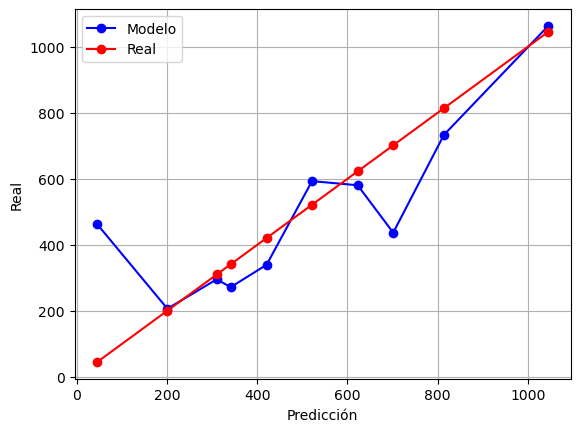

In [18]:
Models(X_sig, y).linear_regression()

R2 del modelo: 0.2890


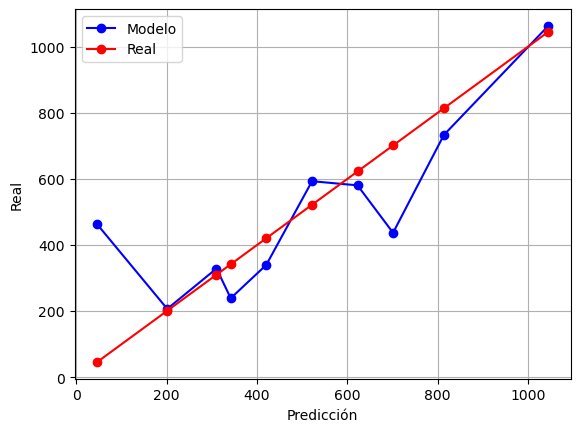

In [19]:
Models(X_sig, y).linear_ridge()

R2 del modelo: 0.2889


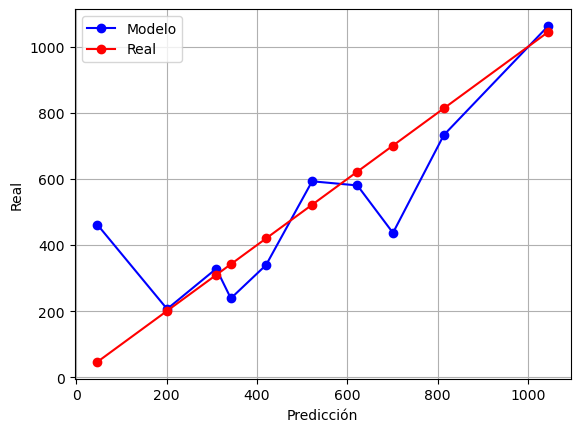

In [20]:
Models(X_sig, y).linear_lasso()

Los tres modelos tienen un r2 muy similar de un poco más de 0.28, lo que significa que son peores que el modelo de KNN previamente realizado.

### Modelos polinomiales

R2 del modelo: 0.3302


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.233e+06, tolerance: 4.367e+03
  model = cd_fast.enet_coordinate_descent(


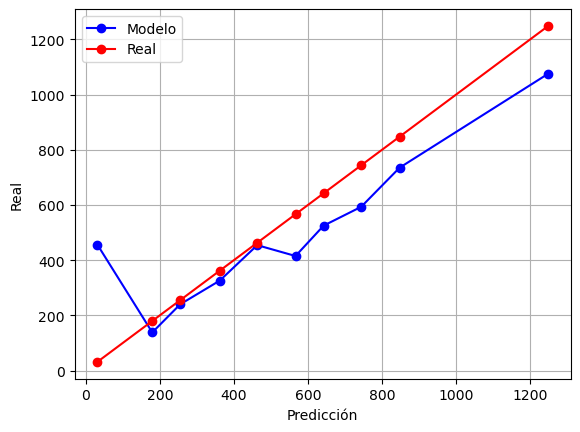

In [21]:
Models(X_sig, y).polinomial_regression(2)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.999e+05, tolerance: 4.367e+03
  model = cd_fast.enet_coordinate_descent(


R2 del modelo: -0.0337


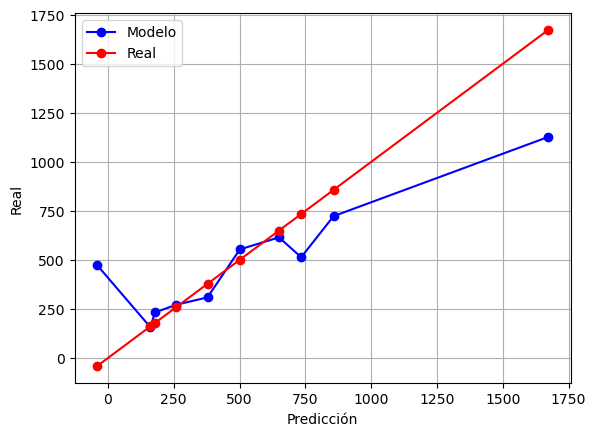

In [22]:
Models(X_sig, y).polinomial_regression(3)

Una vez realizados los modelos polinomiales vemos que el modelo de grado 2 es el emjor hasta el momento con un r2 de 0.3302, en el cual solo utilizamos las variables que se podrían considerar sinificativas.

### KNN

,nn,r2
9,10,0.321541


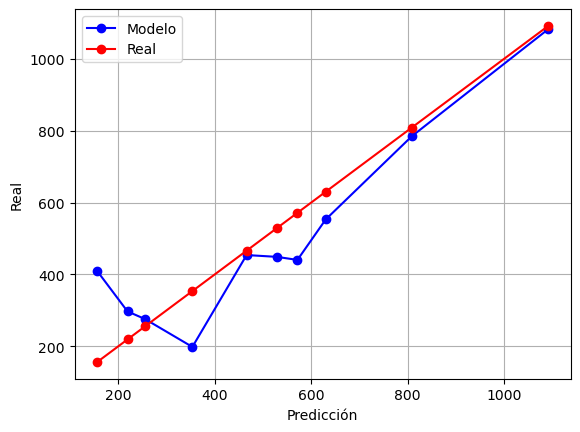

In [23]:
Models(X_sig, y).knn()

Si bien mejoró en comparación con el KNN inicial con todas las variables, no es mejor el modelo polinomial de grado 2 obtenido usando solo las variables significativas.

Se podría decir que ya se probaron todos los modelos base, para buscar hacer un mejor modelo se puede optar por hacer feature engineering, ya sea transformaciones de variables, creación de nuevas, o las numéricas hacerlas categóricas.

## Feature Engineering

### Visualización de los datos

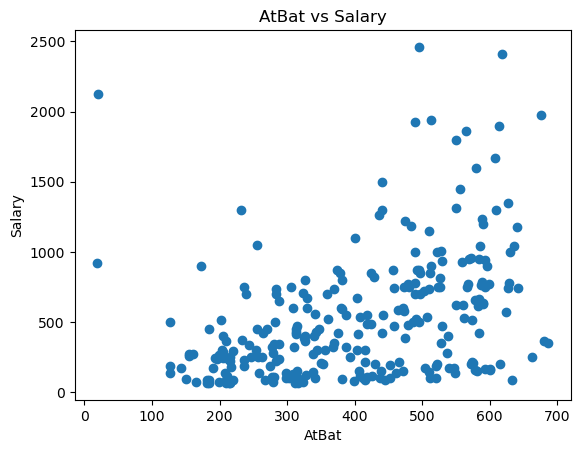

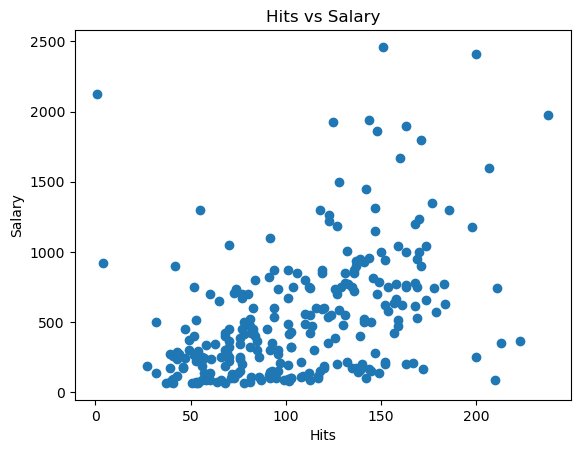

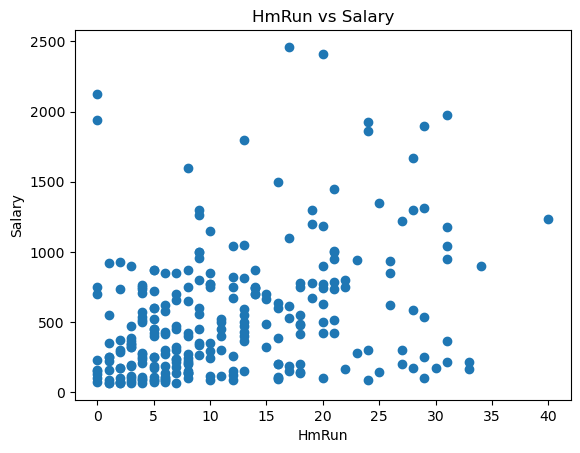

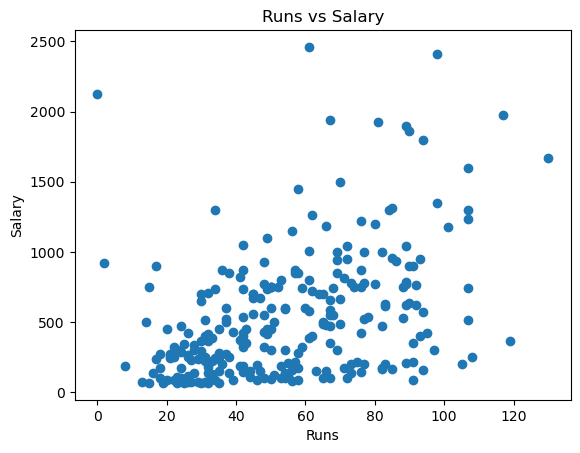

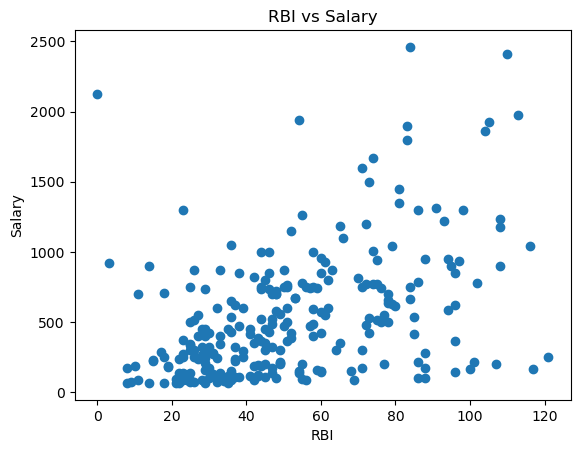

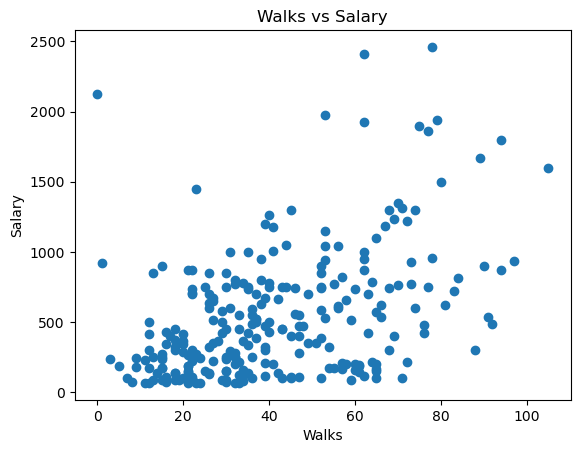

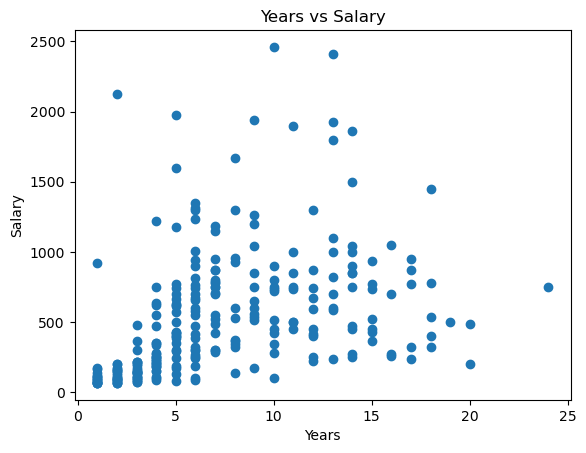

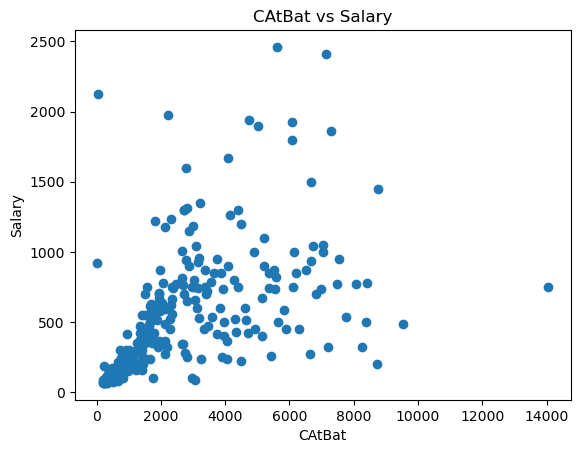

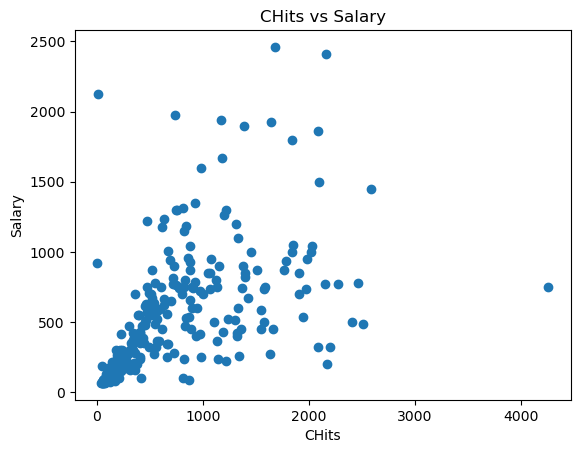

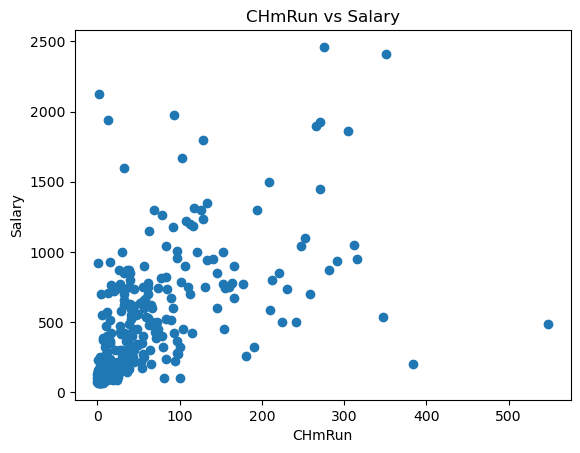

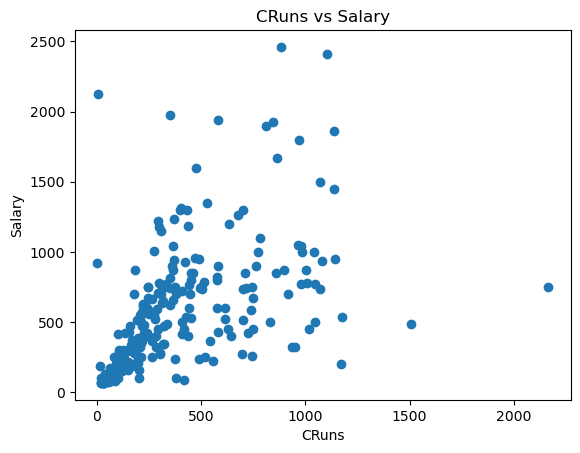

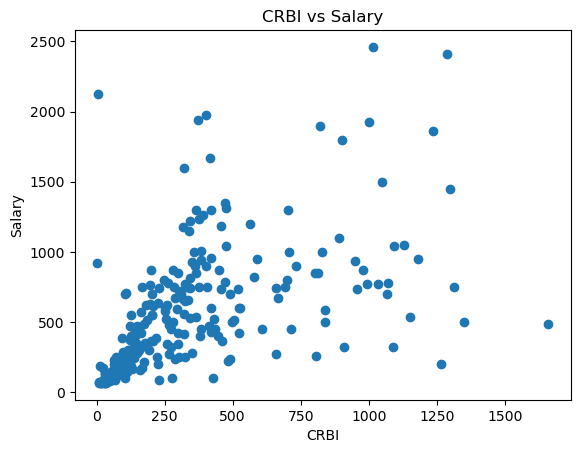

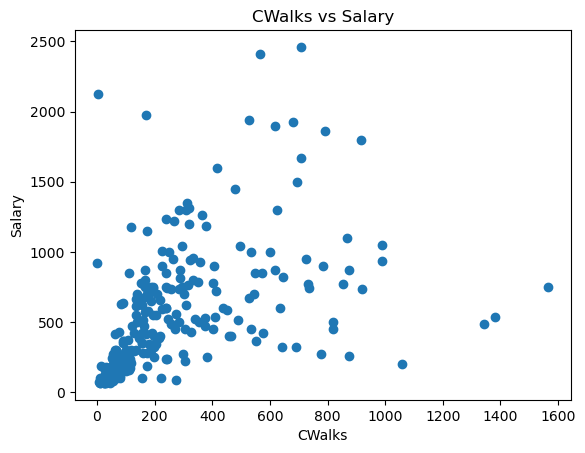

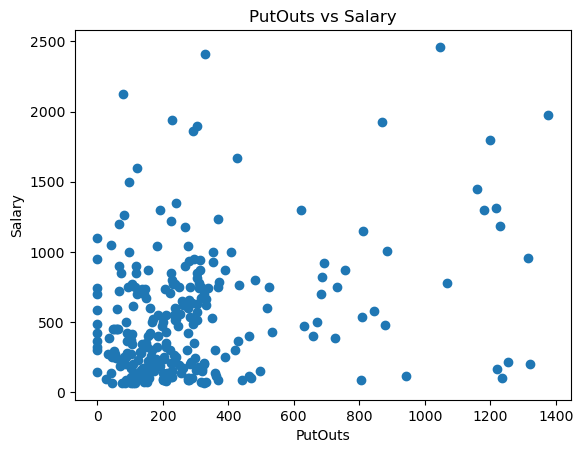

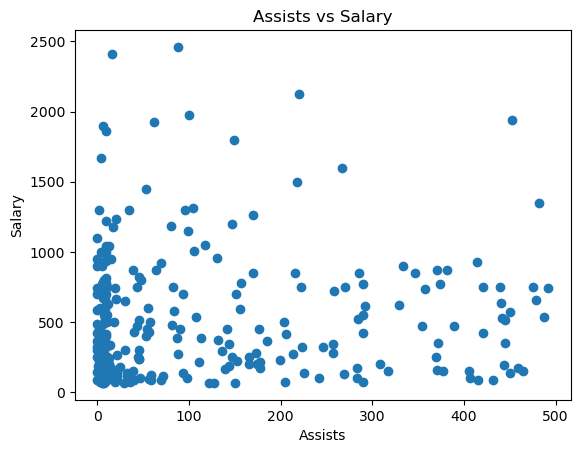

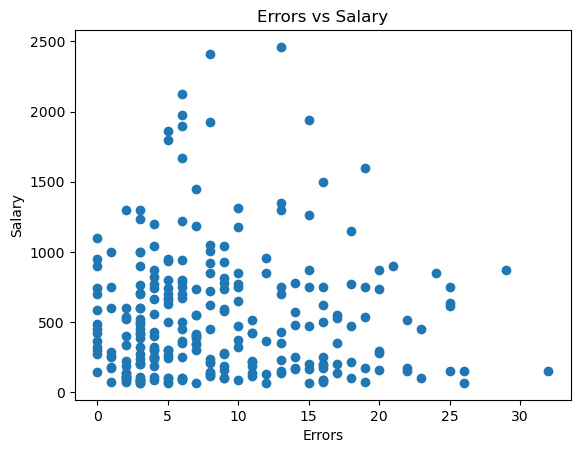

In [24]:
num_features = data.iloc[:, :-7].columns

scatterplots(data, num_features, target)

Estas gráficas nos ayudan a ver la dispersión de los datos, y en general para casi todas las variables numéricas existe una tendencia alcista, es decir, a mayor cantidad en el eje x, mayor salario, además cabe observar que para las variables acumulativas suelen tener una mayor cantidad de datos concentrados en el lado izquierdo del eje x.

### Análisis bivariado

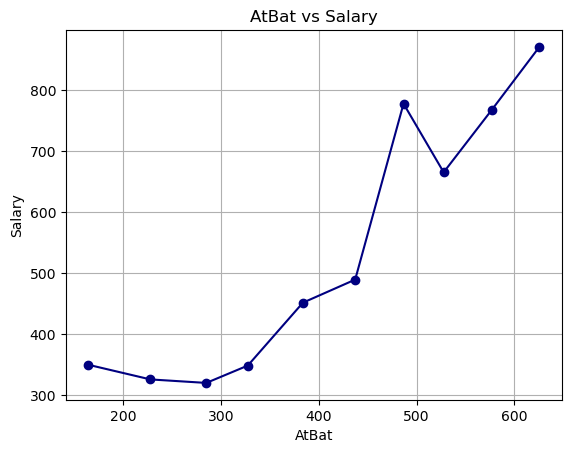

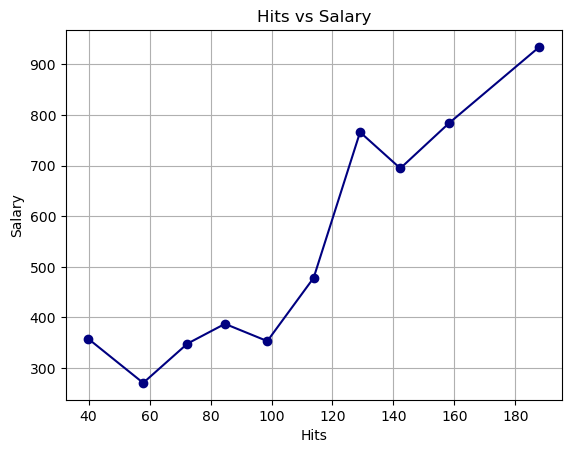

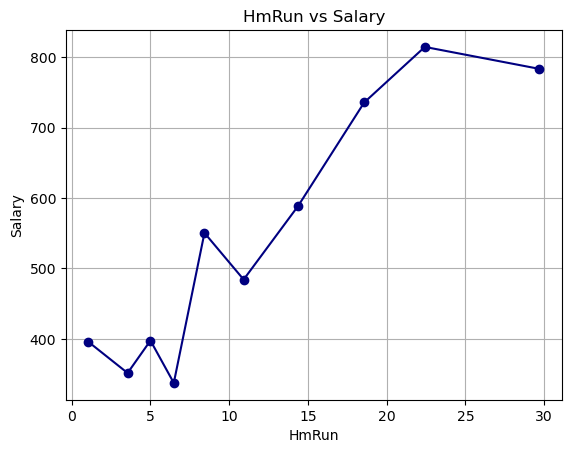

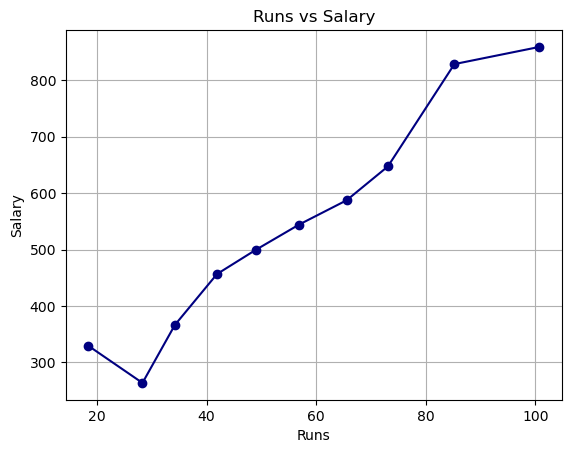

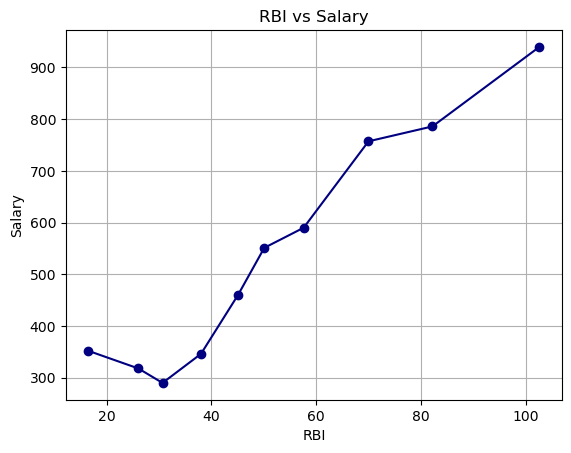

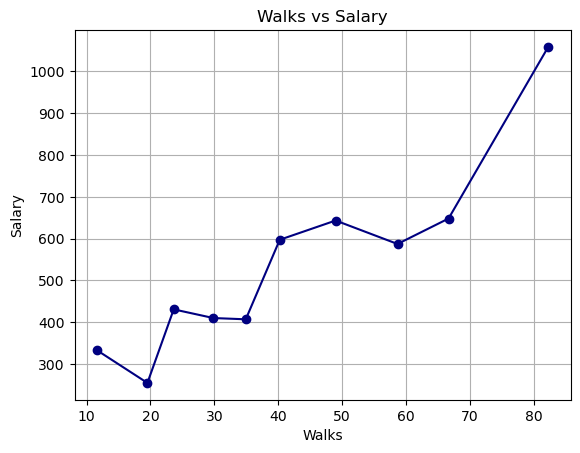

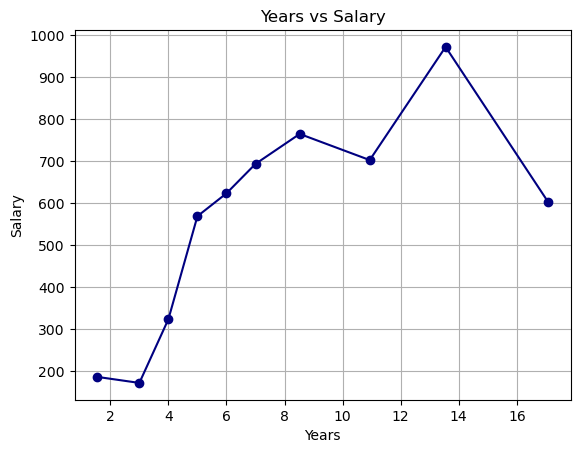

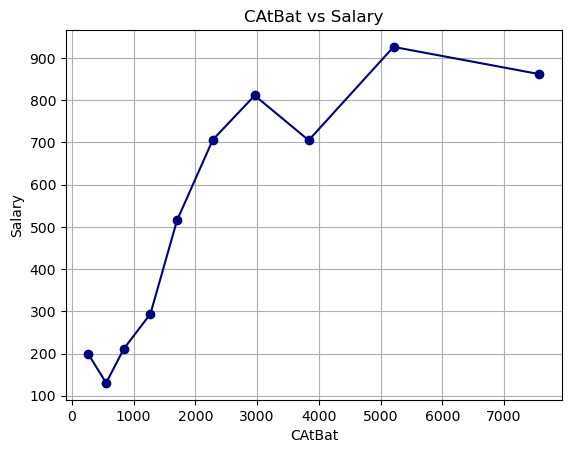

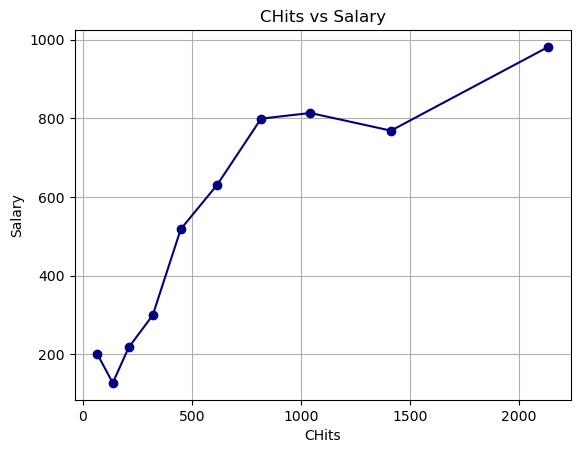

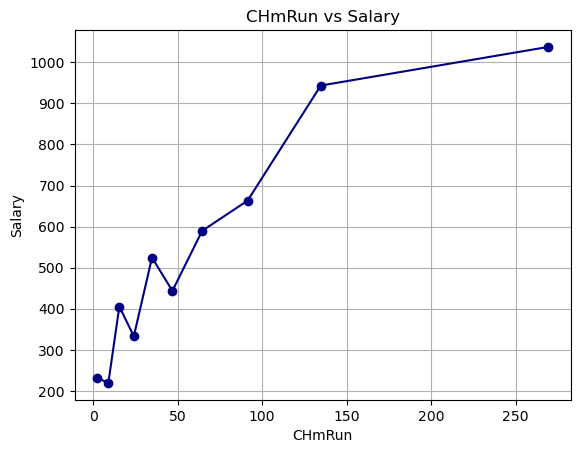

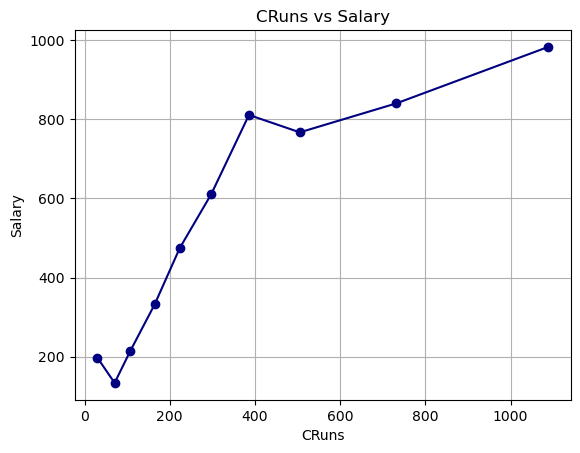

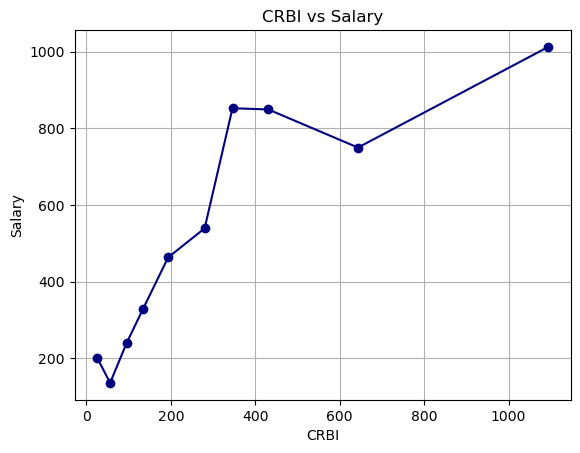

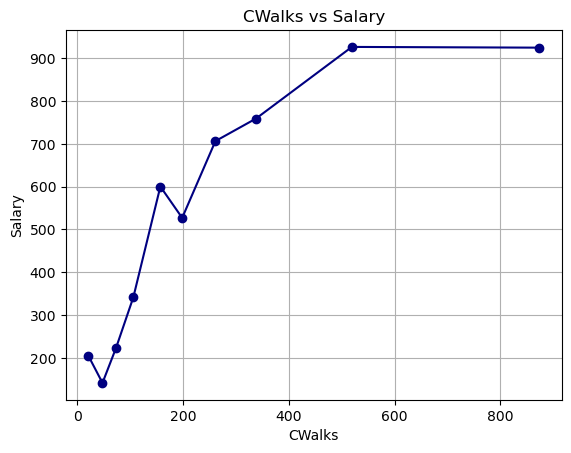

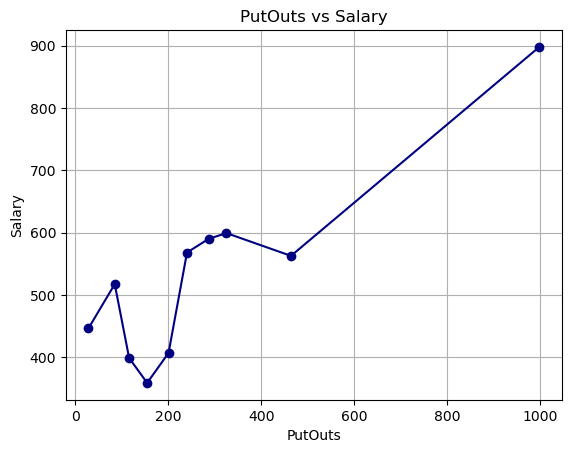

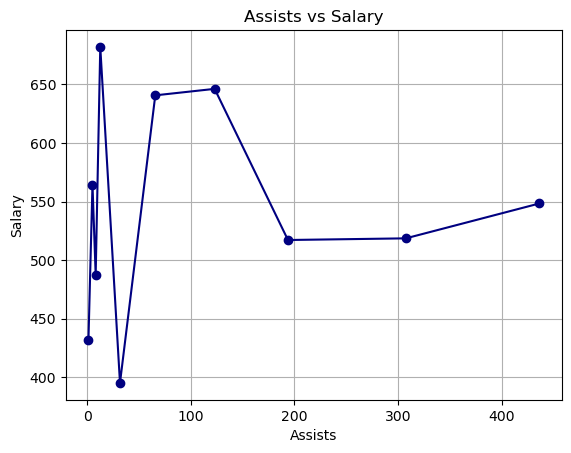

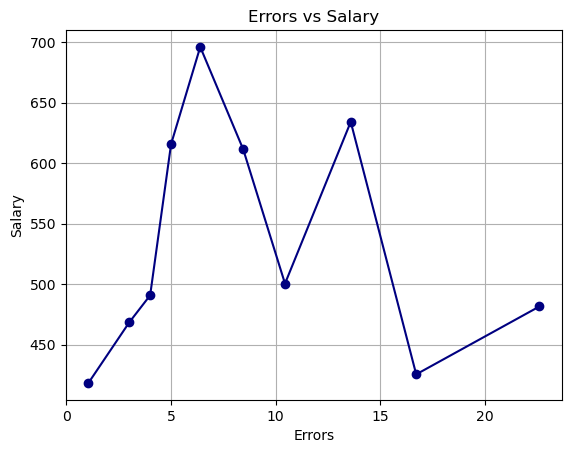

In [25]:
df_numerical = data.iloc[:, :-6]
bivariado(df_numerical, num_features)

Gracias al análisis bivariado se puede ver la relación que existe entre las variables independientes con la dependiente, esto nos puede ayudar a realizar distintas transformaciones de datos. variables como assits y errors tiene una relación muy irregular con respecto al salario, sin embargo, la mayoría de las demás variables tienen una relación similar a una raíz, esto es de utilidad para hacer feaure engineering.

### Boxplot

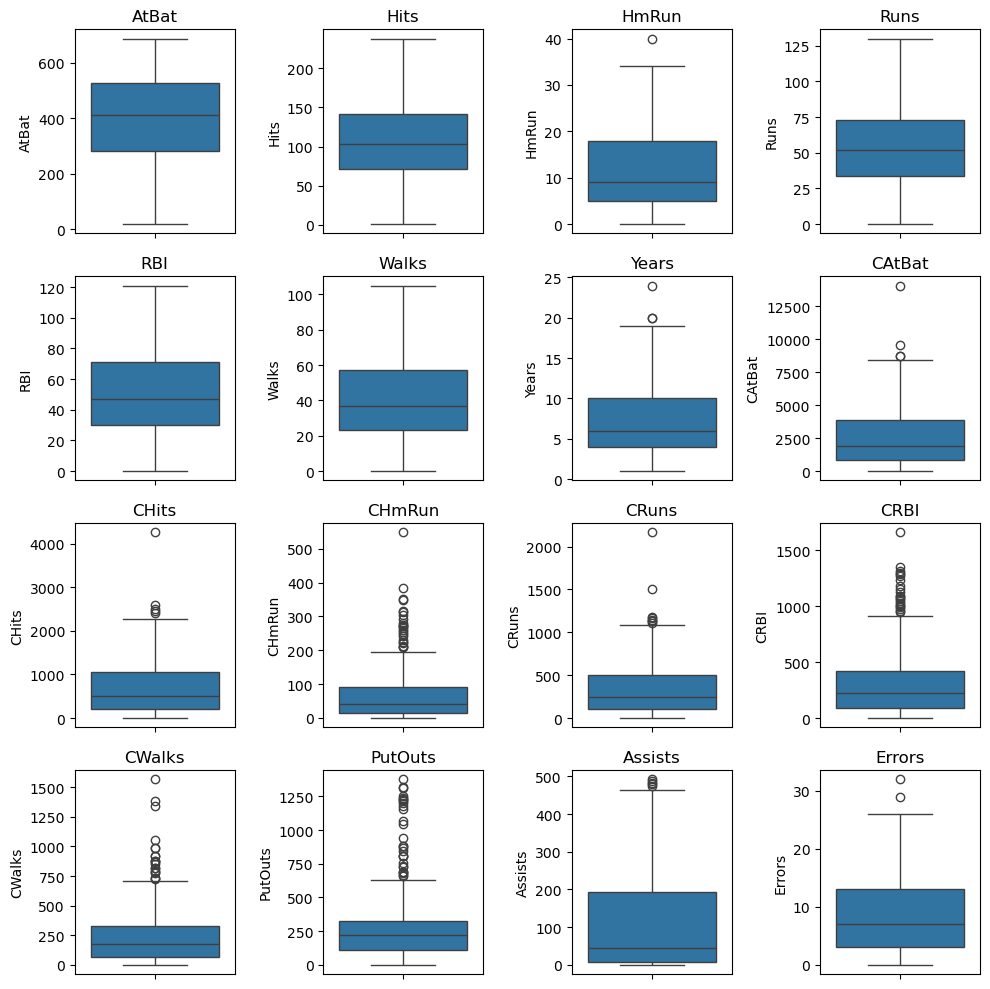

In [26]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
axes = axes.flatten()

for i, feature in enumerate(num_features):
    sns.boxplot(y=data[feature], ax=axes[i])
    axes[i].set_title(feature)
    
plt.tight_layout()
plt.show()

Los boxplots permiten ver la distribución de las variables, las transformaciones logarítmicas son buenas para lidiar con outliers por lo que sería útil ver cueles tienen y aplicar la transformación.

### Creación de variables

In [27]:
# De rendimiento
data['Hits_per_AtBat'] = data['Hits'] / data['AtBat']
data['HmRun_per_Hits'] = data['HmRun'] / data['Hits']

# Rendimiento actual vs histórico
data['Hits_per_CHits'] = data['Hits'] / data['CHits']
data['HmRun_per_CHmRun'] = data['HmRun'] / data['CHmRun']
data['Years_AvgHits'] = data['CHits'] / data['Years']

# Transformaciones
data['log_CHmRun'] = np.log(data['CHmRun']+1)
data['log_CWalks'] = np.log(data['CWalks']+1)
data['log_PutOuts'] = np.log(data['PutOuts']+1)

data['Runs_3'] = data['Runs']**3
data['CHits_8'] = data['CHits']**0.8

In [28]:
pd.DataFrame(data.isnull().sum()).T

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,Hits_per_AtBat,HmRun_per_Hits,Hits_per_CHits,HmRun_per_CHmRun,Years_AvgHits,log_CHmRun,log_CWalks,log_PutOuts,Runs_3,CHits_8
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0


In [29]:
data['HmRun_per_CHmRun'] = data['HmRun_per_CHmRun'].fillna(data['HmRun_per_CHmRun'].mean())

## Probar Modelos

In [30]:
X = data.copy()
X = X.drop(columns=[target])
y = data[target]

### Modelos Lineales

R2 del modelo: 0.6106


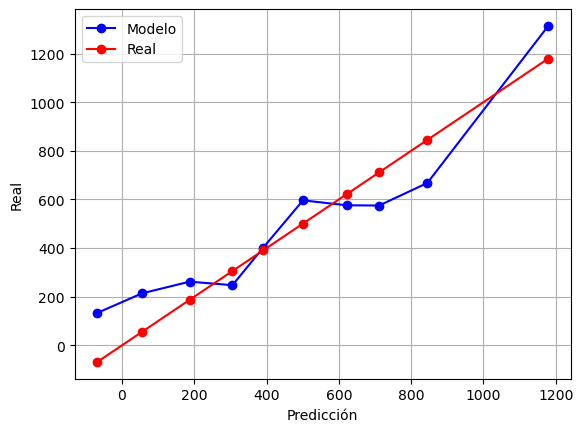

In [31]:
Models(X, y).linear_regression()

Agregando las variables al dataset se obtuvo un buen modelo, con r2 de 0.6105, utilizando una regresión lineal, y como se muestra en la gráfica se ajuste relativamente bueno, sobre todo en los datos centrales, fallando más en la predicción de salarios muy bajos o muy altos.

### Modelos Polinomiales

R2 del modelo: -0.0097


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.159e+05, tolerance: 4.367e+03
  model = cd_fast.enet_coordinate_descent(


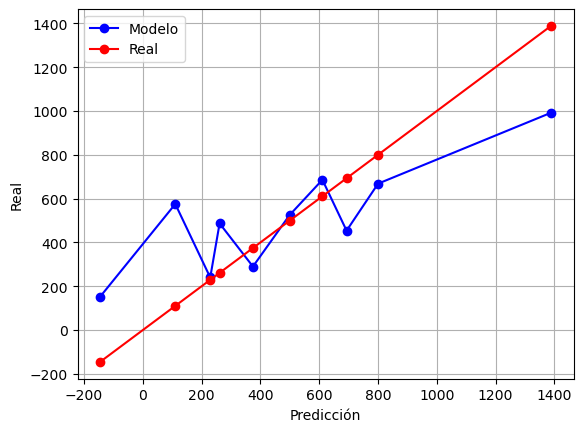

In [32]:
Models(X, y).polinomial_regression(2)

### KNN

,nn,r2
7,8,0.327995


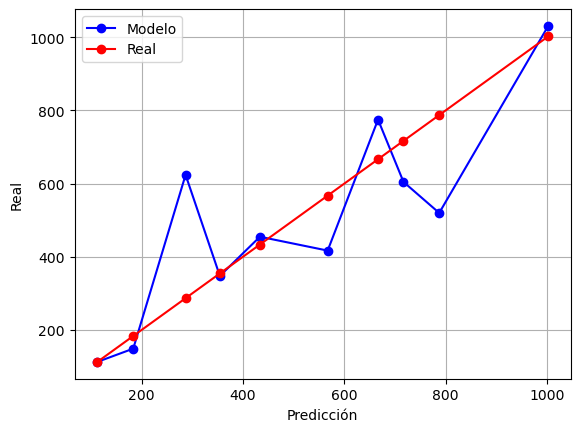

In [33]:
Models(X, y).knn()

Probando un modelo de KNN podemos ver que el r2 no mejora mucho en comparación al KNN anterior a pesar de haber realizado el feature engineering, sin embargo, es bastante inferiror a la regresión lineal realizada.

### Variables numéricas a categóricas

In [34]:
numerical_features = data.columns.drop(['Salary' ,'League_A', 'League_N', 'Division_E', 'Division_W', 'NewLeague_A', 'NewLeague_N', 'Years', 'HmRun_per_CHmRun'])

In [35]:
# División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, data[target], test_size=0.2, random_state=42)
# Crea funcion bins para las variables numericas 
def create_bins(X, numeric_vars, bins):
    for var in numeric_vars:
        X[f'{var}_bin'] = pd.qcut(X[var], q = bins, labels=False, duplicates='drop') + 1
    return X

# Aplica la foruma de bins a x_trian y x_test
X_train = create_bins(X_train, numerical_features, 10)
X_test = create_bins(X_test, numerical_features, 10)
# Bin features
bins_features = [i for i in X_train.keys() if 'bin' in i]
cat_features = [i for i in X_train.keys() if 'bin' not in i]

# Final features 
final_features = bins_features + cat_features

# Apply get dummies to both pd.get_dummies(X_train[final_features], columns=bin_features, drop_first=True)
X_train = pd.get_dummies(X_train[final_features], columns=bins_features, drop_first=True)
X_test = pd.get_dummies(X_test[final_features], columns=bins_features, drop_first=True)

In [36]:
model_linear = linear_model.LinearRegression().fit(X_train, y_train)
predicciones_lineal = model_linear.predict(X_test)
r2_score(y_pred = predicciones_lineal, y_true = y_test)

-8.143392941736586

Transformar las variables numéricas a categóricas o fue de gran ayuda para el modelo, pues obtiene un r2 negativo.

### Regresión OLS

Una vez realizado el feature engineering, utilizaremos esta regresión para saber que variables son significativas para nuestro modelo, se hará de igual forma que antes, eliminando la de mayor p-value y repitiendo.

In [37]:
model = smf.ols('Salary ~ ' + ' + '.join(data.columns.drop(['Salary', 'CHmRun', 'Assists', 'CWalks', 'Runs_3', 'Errors', 'RBI', 'log_PutOuts', 'Runs',
                                                            'HmRun_per_CHmRun', 'log_CHmRun', 'HmRun_per_Hits', 'HmRun'])), data = data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     39.94
Date:                Fri, 21 Feb 2025   Prob (F-statistic):           1.02e-60
Time:                        17:34:20   Log-Likelihood:                -1805.5
No. Observations:                 263   AIC:                             3647.
Df Residuals:                     245   BIC:                             3711.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             971.9888    

## Usando variables significativas

In [38]:
X_ols = X.drop(columns=['CHmRun', 'Assists', 'CWalks', 'Runs_3', 'Errors', 'RBI', 'log_PutOuts', 'Runs',
                                                            'HmRun_per_CHmRun', 'log_CHmRun', 'HmRun_per_Hits', 'HmRun'])

### Modelos lineales

R2 del modelo: 0.6631


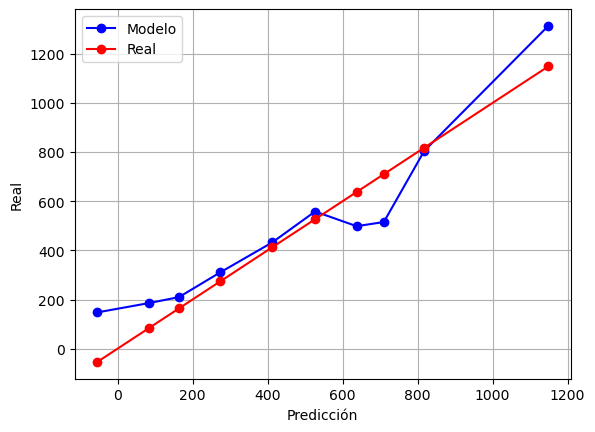

In [39]:
Models(X_ols, y).linear_regression()

Una vez elegidas las variables significativas a través del p-values se obtiene el mejor modelo hasta el momento, con un r2 de 0.6630, lo que significa que el modelo logra explicar el 66.30% de la variación d elos datos, lo cual ya le da cierto poder predictivo para los salarios de los jugadores. En la parte media baja se ajusta bien, su error viene principalmente por los outliers pues en la parte muy baja y muy alta no logra una buena predicción.

### Modelos polinomiales

R2 del modelo: 0.1995


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.131e+05, tolerance: 4.367e+03
  model = cd_fast.enet_coordinate_descent(


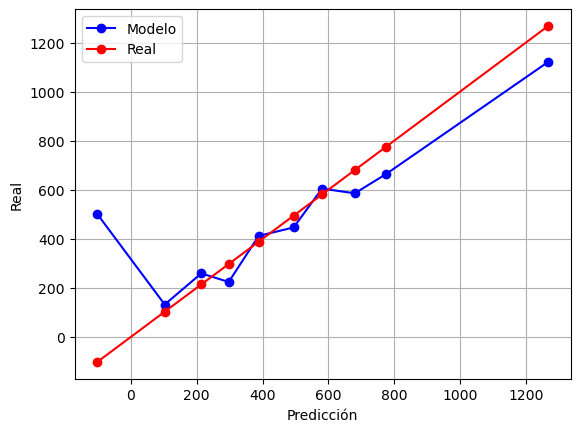

In [40]:
Models(X_ols, y).polinomial_regression(2)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.429e+05, tolerance: 4.367e+03
  model = cd_fast.enet_coordinate_descent(


R2 del modelo: -3.3058


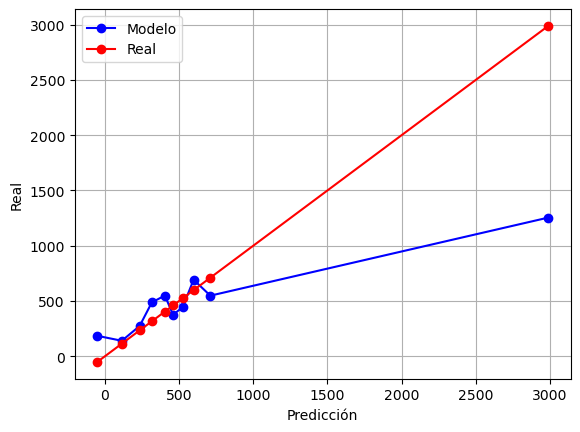

In [41]:
Models(X_ols, y).polinomial_regression(3)

Los modelos polinomiales mostraron un mal desmepeño después de elegir las variables.

### KNN

,nn,r2
11,12,0.363808


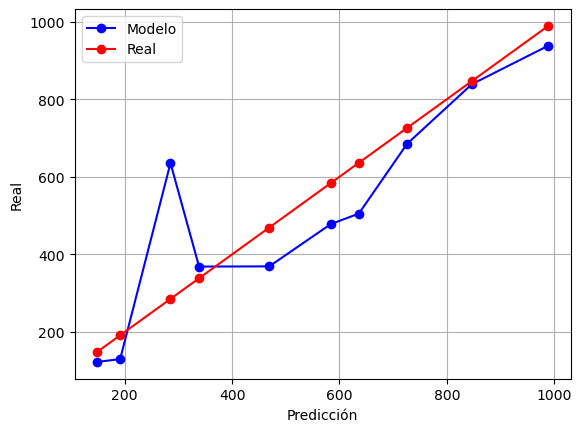

In [42]:
Models(X_ols, y).knn()

De igual forma el KNN tuvo un rendimiento muy malo para la predicción de los salarios.